# Projet SAV 
Binomes : NENNOUCHE Mohamed / ATCHI Abdel Malek
## But du projet 
Le but de ce projet est de parvenir à classer des plaques de signalisations suivant trois classes distinctes : 
1. Les panneaux d’avertissement de danger.
2. Les panneaux d’interdiction ou de restriction.
3. Les panneaux d’obligation

Et cela en utilisant deux méthodes : 
1. En utilisant l’algorithme du k-plus proches voisins.
2. En utilisant un réseau neuronal multicouche.

In [5]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import cmath
import os
import itertools

## Phase de prétraitement
### Lecture de toutes les images

In [6]:
#La fonction suivante nous permettant de télécharger toutes les images d'un dossier et les mettre dans une liste
def Load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            images.append(img)
    return images

images_avertissement = Load_images("Traffic-routier/Avertissement")
images_interdiction = Load_images("Traffic-routier/Interdiction_restriction")
images_obligation = Load_images("Traffic-routier/Obligation")


### On applique un filtre médian sur toutes les images nous permettant d'enlever un éventuel bruit impulsionnel

In [7]:
for (i,j,k) in zip(range(len(images_avertissement)),range(len(images_interdiction)),range(len(images_obligation))) :
    images_avertissement[i] = cv.medianBlur(images_avertissement[i],3)
    images_interdiction[j] = cv.medianBlur(images_interdiction[j],3)
    images_obligation[k] = cv.medianBlur(images_obligation[k],3)

### On réalise une conversion de l’espace RGB vers l’espace Y’CbCr
tels qu'on a : 
$$
𝑌′ =0.299𝑅+0.587𝐺+0.114𝐵 
$$
$$
𝐶_𝑏 =−0.1687𝑅−0.3313𝐺+0.5𝐵+128 
$$
$$
𝐶_𝑟  =0.5𝑅−0.4187𝐺−0.0813𝐵+128
$$

In [8]:
# Cette fonction traverse toute la liste convertissant toutes les images et retournant la nouvelle liste
def conv_RGB_YCbCr (listimage) :
    channels = [] 
    y = [] 
    Cb = [] 
    Cr = [] 
    nouvelles_images = []
    for i in range(len(listimage)) :
        channels.append(cv.split(listimage[i])) 
        y.append(0.299*channels[i][0] + 0.587*channels[i][1] + 0.114*channels[i][2])
        Cb.append(-0.1687*channels[i][0] - 0.3313*channels[i][1] + 0.5*channels[i][2] + 128)
        Cr.append(0.5*channels[i][0] - 0.4187*channels[i][1] - 0.0813*channels[i][2] + 128)
        nouvelles_images.append(cv.merge([y[i],Cb[i],Cr[i]]))
        nouvelles_images[i] = np.uint8(nouvelles_images[i])
    return nouvelles_images
nouvelles_avertissement = conv_RGB_YCbCr(images_avertissement)
nouvelles_obligation = conv_RGB_YCbCr(images_obligation)
nouvelles_interdiction = conv_RGB_YCbCr(images_interdiction)

### Maintenant on procède au redimensionnement des images pour avoir des images de tailles : 64x128 pixels

In [9]:
# Fonction nous permettant de traverser la liste et de redimensionner les images
def image_resizer (listimage) :
    dim = (64, 128)
    for i in range(len(listimage)) :
        listimage[i] = cv.resize(listimage[i],dim)
image_resizer(nouvelles_avertissement)
image_resizer(nouvelles_obligation)
image_resizer(nouvelles_interdiction)

### On calcule maintenant l’histogramme des gradients orientés pour chaque images de nos trois classes et on aura alors : 

In [10]:
# Fonction permettant le calcul du HOG pour une liste d'image
def hog_list (listimage) :
    fv = []
    hog_image = []
    for i in range(len(listimage)) :
        a, b = hog(listimage[i], orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
        fv.append(a)
        hog_image.append(b)
    return fv,hog_image
fv_avertissement,hog_image_avertissement = hog_list(nouvelles_avertissement)
fv_obligation,hog_image_obligation = hog_list(nouvelles_obligation)
fv_interdiction,hog_image_interdiction = hog_list(nouvelles_interdiction)
    

### Normalisation de nos données suivant une echelle 0 à 1
Cette étape est déjà faite au niveau de la fonction HOG, toutes les valeurs sont comprises entre 0 et 1, donc maintenant on va procéder à la fusion des données ainsi qu'à leur étiquetage, pour tester la prédiction faite par notre modèle
### On procède à la fusion et l'étiquetage de nos données
En commençant par l'étiquetage, en créant une autre liste avec l'étiquette tels que : 
- Panneaux d'avertissement : y = 0
- Panneaux d'obligation : y = 1
- Panneaux d'interdiction : y = 2

In [11]:
# L'étiquetage se fera à travers l'utilisation d'une fonction
def etiquetage (listimage, etiquette) :
    etiq = []
    for i in range(len(listimage)) :
        etiq.append(etiquette)
    return etiq
etiq_avertissement = etiquetage(fv_avertissement,0)
etiq_obligation = etiquetage(fv_obligation,1)
etiq_interdiction = etiquetage(fv_interdiction,2)

# Maintenant procédons à la fusion des listes pour avoir notre dataset 
fv = fv_avertissement + fv_obligation + fv_interdiction
etiq = etiq_avertissement + etiq_obligation + etiq_interdiction

# Pour pouvoir utiliser les données on va alors transformer cette liste de listes en dataframe
fv = pd.DataFrame(fv)
etiq = np.array(etiq)
fv

,0,1,2,3,4,5,6,7,8,9,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
0,0.259585,0.016082,0.303638,0.050039,0.047875,0.022178,0.021203,0.091840,0.391313,0.192779,...,0.011880,0.303558,0.248541,0.097625,0.201094,0.303558,0.136716,0.071568,0.069259,0.184132
1,0.048966,0.013012,0.024071,0.007404,0.014548,0.004337,0.010973,0.028716,0.012011,0.068424,...,0.060487,0.293280,0.074039,0.045012,0.019403,0.103125,0.046107,0.094264,0.054810,0.293280
2,0.349463,0.349463,0.149760,0.031988,0.316478,0.026489,0.047940,0.063608,0.082442,0.233397,...,0.385284,0.304801,0.016811,0.029042,0.010862,0.020868,0.003746,0.002944,0.008125,0.031930
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.327465,0.093962,0.000000,0.000000,0.290734,0.000000,0.180635,0.267148,0.313126
4,0.194230,0.010624,0.024353,0.045435,0.125289,0.083547,0.075094,0.341454,0.232796,0.341454,...,0.389883,0.168620,0.000000,0.038201,0.008275,0.128764,0.066497,0.261858,0.322760,0.048145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.307653,0.022737,0.008909,0.000000,0.031499,0.023254,0.035706,0.307653,0.307653,0.307653,...,0.000000,0.006867,0.000000,0.007950,0.019750,0.449491,0.287196,0.009335,0.012337,0.000000
146,0.319718,0.039717,0.050239,0.000000,0.088811,0.079435,0.200955,0.099293,0.028084,0.385300,...,0.015642,0.169669,0.009540,0.000000,0.000000,0.305253,0.324128,0.193038,0.093677,0.040360
147,0.392175,0.140068,0.382665,0.123899,0.083074,0.107005,0.081169,0.069892,0.386412,0.392175,...,0.081263,0.277841,0.028715,0.006012,0.005139,0.017618,0.000000,0.007583,0.353427,0.353427
148,0.031385,0.014350,0.009069,0.036081,0.022015,0.009407,0.005961,0.016177,0.006150,0.473913,...,0.021329,0.366819,0.072998,0.007833,0.000000,0.012186,0.000000,0.007093,0.025310,0.105510


On a alors dans cette première partie fait tout le pré-traitement des images qui consiste à : 
- La lecture de toutes les images qu'on a. 
- Application d'un filtre médian sur les images.
- Conversion de nos images de l'espace RGB à l'espace $Y'C_bC_r$.
- Redimensionnement de toutes les images à une taille de 64x128 pixels.
- Calcul de l'histogramme des gradients orientés pour chacune des images qu'on a. 
- Etiquetage et fusion de nos données.

Maintenant on passe à la classification des images
## Classification des images
### K-plus proches voisins 
#### Partage du dataset en dataset d'entrainement et dataset de test

In [12]:
# On utilise pour cela la librairie sklearn pour diviser aléatoirement nos données en groupe d'entrainement et de test
fv_train, fv_test, etiq_train, etiq_test = train_test_split(fv, etiq, test_size=0.8,random_state=42) 
print("Le nombre d'échantillon d'entrainement = ",fv_train.shape)
print("Le nombre d'échantillon de test = ",fv_test.shape)

Le nombre d'échantillon d'entrainement =  (30, 3780)
Le nombre d'échantillon de test =  (120, 3780)


#### On passe maintenant à la classification utilisant l'algorithme K-plus proches voisins
L'implémentation se fera à travers la librairie sklearn étant donné que l'algorithme est déjà implémenté, on commence par une implémentation détaillée et puis on verra l'influence des paramètres : 
1. Mesure de la distance choisie : 
    - Distance Euclidienne :
    $$
        D(a,b) = sqrt(\sum^n_{i=1}|a_i - b_i|^2)
    $$
    - Distance Manhattan
    $$
        D(a,b) = \sum^n_{i=1}|a_i - b_i|
    $$
    - Distance Canberra
    $$
        D(a,b) = \sum^n_{i=1}\frac{|a_i-b_i|}{|a_i+b_i|}
    $$
2. Le choix du k (k=1,3,5,7 et 9)

Alors on commence par la phase d'apprentissage

In [13]:
K=5
# la mesure de distance est mise par défaut et c'est donc une distance Euclidienne
voisin = KNeighborsClassifier(n_neighbors = K, p = 2).fit(fv_train,etiq_train)

Maintenant on passe à la phase prédiction sur l'ensemble de test

In [14]:
ypredict = voisin.predict(fv_test)

Maintenant on passe au calcul de performance de notre modèle avec le calcul de certaines métriques en utilisant aussi la librairie sklearn

In [15]:
print("Taux de précision lors de l'entrainement : ",metrics.accuracy_score(etiq_train, voisin.predict(fv_train)))
print("Taux de précision lors des tests : ",metrics.accuracy_score(etiq_test, ypredict))

Taux de précision lors de l'entrainement :  0.8666666666666667
Taux de précision lors des tests :  0.8416666666666667


Observons maintenant l'impact de la variation des paramètres en faisant la combinaison de toutes les possibilités avec les trois mesures de distances ainsi que la variation de k (k=1,3,5,7 et 9)

In [16]:
train_test = []
for k in range(1,10,2) :
    for i in range(1,4) : 
        voisin = KNeighborsClassifier(n_neighbors = k, p = i).fit(fv_train,etiq_train)
        ypredict = voisin.predict(fv_test)
        train_test.append(metrics.accuracy_score(etiq_test, ypredict))
print(train_test)


[0.9416666666666667, 0.9166666666666666, 0.8916666666666667, 0.925, 0.9, 0.8833333333333333, 0.9083333333333333, 0.8416666666666667, 0.825, 0.9, 0.8333333333333334, 0.775, 0.85, 0.8, 0.7583333333333333]


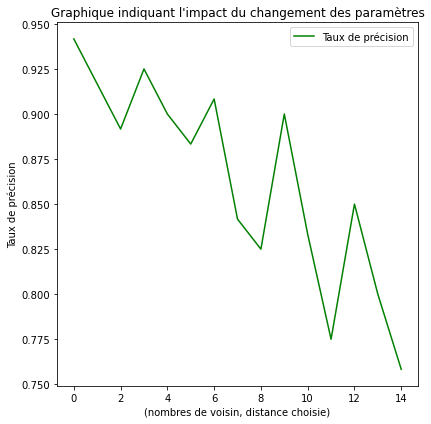

In [17]:
plt.figure(figsize=(6,6))
plt.plot(range(0,15),train_test,'g', label='Taux de précision')
plt.title("Graphique indiquant l'impact du changement des paramètres")
plt.legend(loc="upper right")
plt.ylabel("Taux de précision")
plt.xlabel("(nombres de voisin, distance choisie)")
plt.tight_layout()
plt.show()

On observe bien que la meilleure précision a été au niveau de la première et la deuxième mesure qui correspondent respectivement à 1 voisin et l'utilisation de la distance Euclidienne et 1 voisin et l'utilisation de la distance de Canberra avec une précision d'environ 96.67%, on choisit de prendre celui qui utilise la distance Euclidienne pour le calcul de la matrice de confusion. 

Sinon on voit que globalement, l'effet de l'ajout de voisins impactent négativement la classification des plaques de signalisation, aussi par rapport à la mesure de distance choisie on peut facilement observer que pour n'importe quel k choisi la meilleure mesure est toujours faite par celle utilisant une distance Euclidienne, faisant de cette distance le choix approprié à ce problème.

#### Calcul de la matrice de confusion dans le cas d'un voisin et d'une distance Euclidienne

In [18]:
voisin = KNeighborsClassifier(n_neighbors = 1, p = 2).fit(fv_train,etiq_train)
ypredict = voisin.predict(fv_test)
print("Matrice de confusion : \n",metrics.confusion_matrix(etiq_test, ypredict))

Matrice de confusion : 
 [[43  0  0]
 [ 0 29 10]
 [ 0  0 38]]


On observe bien que le classifieur a globalement bien fonctionné, on peut alors donner les remarques suivantes : 
- La classe des plaques d'avertissement a été parfaitement classée et cela s'explique par le fait qu'elle a une forme différente des deux autres classes (avertissement : triangle, le reste : rond), ce qui a permi d'avoir une classification efficace.
- La classe des plaques d'interdiction et des plaques d'obligation ont globalement été très bien classées (la classe d'interdiction a été parfaitement classée), la classe d'obligation on a 4 faux négatifs qui ont été classés parmis les plaques d'interdiction et ceci s'explique par le fait que les deux classes de panneaux ont la même formes, et que le changement de bases de couleurs dans ce cas n'a pas été assez efficace pour différencier la couleur bleu des plaques d'obligation de la couleur rouge des plaques d'interdiction. 
### Réseau de neurones multicouche
Et donc on utilise un réseaux de neurones multicouches utilisant encore une fois la librairie scikitlearn, le défi dans l'utilisation des réseaux de neurones est le choix du nombres de neurones et de couches à utiliser, étant un problème assez simple, une seule couche cachée suffit amplement, maintenant comment définir le nombre minimal de neurones nous permettant d'avoir un résultat optimal 

In [19]:
accuracy_train = []
accuracy_test = []
for i in range(1,8) :
    modele = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(i), random_state=1).fit(fv_train,etiq_train)
    accuracy_train.append(metrics.accuracy_score(etiq_train, modele.predict(fv_train)))
    accuracy_test.append(modele.score(fv_test,etiq_test))
print(accuracy_train)
print(accuracy_test)


[0.7666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6416666666666667, 0.8, 0.9916666666666667, 0.9833333333333333, 0.925, 1.0, 1.0]


On voit bien que les résultats de l'entrainement sont parfaitement prévisible, il reconnait les données avec lesquels il s'est entrainé, et on voit quelque chose d'intéressant avec les résultats de tests, qu'avec 4 neurones on a de meilleurs résultats qu'avec 5 ou 6 neurones faisant de ce choix le plus optimal dans notre étude, on va procéder à une visualisation de ces résultats : 

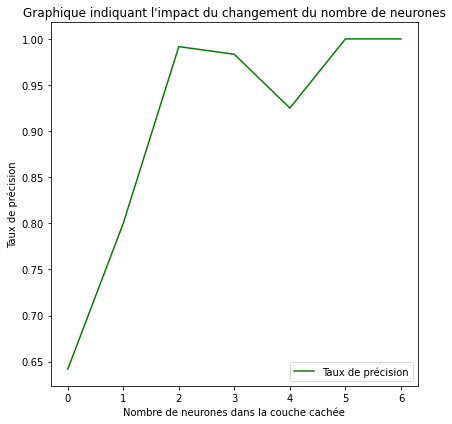

In [20]:
plt.figure(figsize=(6,6))
plt.plot(range(0,7),accuracy_test,'g', label='Taux de précision')
plt.title("Graphique indiquant l'impact du changement du nombre de neurones")
plt.legend(loc="lower right")
plt.ylabel("Taux de précision")
plt.xlabel("Nombre de neurones dans la couche cachée")
plt.tight_layout()
plt.show()

Et par conséquent on choisit notre modèle avec 4 neurones dans la couche cachée, qui nous donne un résultat de 100% dans la phase de test

In [21]:
modele = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4), random_state=1).fit(fv_train,etiq_train)
print("Taux de précision lors de l'entrainement : ",metrics.accuracy_score(etiq_train, modele.predict(fv_train)))

Taux de précision lors de l'entrainement :  1.0


In [22]:
modele.score(fv_test,etiq_test)

0.9833333333333333

On voit ainsi la puissance du réseau de neurones multicouche, donnant des résultats bien plus probants que ceux eu avec l'algorithme K-plus proche voisin, avec le même dataset d'entrainement de test. On peut maintenant visualiser les coefficients de notre réseaux de neurones et plus spécialement celui de notre couche cachée :

In [23]:
print("Les coefficients du réseaux de neurones : \n",modele.coefs_)


Les coefficients du réseaux de neurones : 
 [array([[-0.01076022,  0.0313519 ,  0.01804557, -0.03922776],
       [-0.02675885, -0.0356172 ,  0.0004559 ,  0.00215207],
       [-0.00963336, -0.01257853,  0.00547722,  0.01521939],
       ...,
       [ 0.01701546, -0.03464886,  0.04933212,  0.00656962],
       [ 0.01390691, -0.03846953,  0.05489867,  0.00537139],
       [ 0.00371251, -0.0335919 , -0.01768188, -0.02093867]]), array([[ 0.48887135, -0.07356309, -0.40818202],
       [ 1.28223641,  0.75761849, -1.27499841],
       [-0.47086283,  0.81620847,  1.37491536],
       [ 0.85548721, -0.20436771,  0.7816823 ]])]


In [24]:
print("Les coefficients de la couche cachée : \n",modele.coefs_[1])

Les coefficients de la couche cachée : 
 [[ 0.48887135 -0.07356309 -0.40818202]
 [ 1.28223641  0.75761849 -1.27499841]
 [-0.47086283  0.81620847  1.37491536]
 [ 0.85548721 -0.20436771  0.7816823 ]]


On voit maintenant la matrice de confusion de notre modèle 

In [25]:
ymodele = modele.predict(fv_test)
print("Matrice de confusion : \n",metrics.confusion_matrix(etiq_test, ymodele))

Matrice de confusion : 
 [[43  0  0]
 [ 0 37  2]
 [ 0  0 38]]


On voit effectivement ici une classification parfaite de nos images dansles trois classes comme il le faut. Faisant ainsi de cette méthode, une méthode plus puissante que la précédente dans la classification des images. On peut ainsi comparer nos deux modèles : 
- En terme de précision il est clair que le réseaux de neurones multicouche est largement vainqueur. 
- Par contre, en terme de simplicité de l'algorithme, l'algorithme du K-plus proches voisins est bien plus simple et donc bien plus simple à implémenter et donne d'assez bons résultats qu'on peut aisément améliorer avec un dataset plus large. 
- En définitif dans des cas de classifications simples comme ici, le choix d'un algorithme simple comme K-plus proches voisins est parfaitement plausible, on opte néanmoins pour l'utilisation d'un réseau de neurones nous donnant une précision parfaite sur le dataset utilisé. 
#### Images qui ont été mal classée
Vis-à-vis du réseaux de neurones on n'a aucune image mal classée, par rapport au K-plus proches voisins on en a 4 qu'on va retrouver : 

classes théoriques : 
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2
 1 1 2 1 0 1 2 0 0 1 1 0 2 0 0 1 1 2 1 2 2 1 0 0 2 2 0 0 0 1 2 0 2 2 0 1 1
 2 1 2 0 2 1 2 1 1]
classes trouvées avec le modèle : 
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 2 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 2 0 2 2 0 2 2 0 2 2
 2 1 2 2 0 1 2 0 0 2 1 0 2 0 0 1 1 2 1 2 2 2 0 0 2 2 0 0 0 1 2 0 2 2 0 1 1
 2 1 2 0 2 2 2 1 2]
les indices des erreurs sont : 
 [18, 64, 66, 69, 74, 77, 83, 95, 116, 119]
Les vecteurs correspondants sont : 
 [array([0.12306784, 0.01017349, 0.03538855, ..., 0.0340385 , 0.2439479 ,
       0.3230465 ]), array([0.15676575, 0.10424871, 0.12938936, ..., 0.24509518, 0.1446519 ,
       0.04721174]), array([0.24527988, 0.18767346, 0.03806167, ..., 0.06528774, 0.15774553,
       0.2144245 ]), array([0.28982359, 0.02948161, 0.05593742, ..., 0.21450079

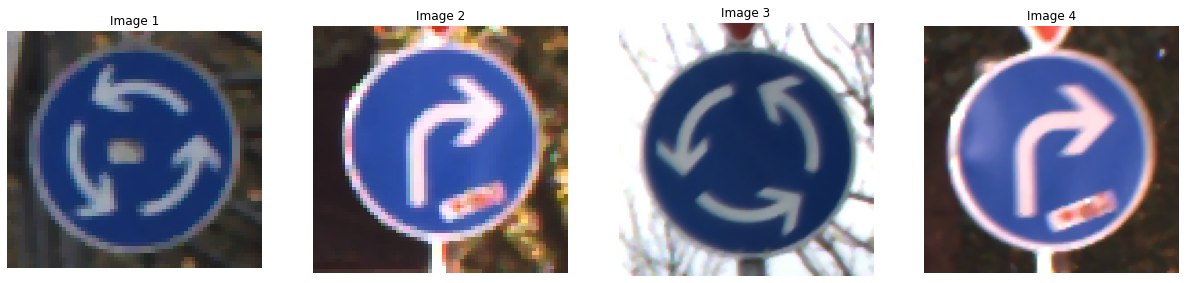

In [26]:
# On va comparer la liste des résultats retrouvés avec le modèle et les prédictions 
print("classes théoriques : \n",etiq_test)
print("classes trouvées avec le modèle : \n",ypredict)
malclasse = []
for i in range(len(ypredict)) :
    if ypredict[i] != etiq_test[i] :
        malclasse.append(i)
print("les indices des erreurs sont : \n",malclasse)

# Maintenant on essaye de retrouver les images à qui cela appartient :
vecteurmalclasse = []
fv_test_tab = fv_test.to_numpy()
fv_tab = fv.to_numpy()
for i in range(len(malclasse)) :
    vecteurmalclasse.append(fv_test_tab[malclasse[i]])
print("Les vecteurs correspondants sont : \n",vecteurmalclasse)

# Comparons les valeurs de ces vecteurs avec les valeurs dans le dataset pour retrouver les indices des images
indices_imagesmal_classee = []
for i in range(len(fv_tab)) :
    for j in range(len(vecteurmalclasse)) :
        vrai = 1
        for l in range(len(vecteurmalclasse[j])) :
            if fv_tab[i][l] != vecteurmalclasse[j][l] :
                vrai = 0
        if vrai == 1 :  
            indices_imagesmal_classee.append(i)
        
print("les indices des images mal classées dans le dataset de départ sont : ",indices_imagesmal_classee)

# les indices retrouvés et confortant notre prédiction que c'est des plaques d'obligation on va les afficher maintenant
print("sachant que le dataset est classé de tels façon à avoir la disposition suivante : \n 50 premiers avertissement ensuite 50 obligation et ensuite 50 interdiction")
print("Donc les indices sont les indices de plaques d'obligations suivants : ")
for i in range(len(indices_imagesmal_classee)) : 
    print(indices_imagesmal_classee[i]-50)
print("Qui représente les images suivantes : ")
# On a donc les indices pour les images 

plt.figure(figsize=(21,7))
plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(images_obligation[indices_imagesmal_classee[0]-50])
plt.title("Image 1")

plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(images_obligation[indices_imagesmal_classee[1]-50])
plt.title("Image 2")

plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(images_obligation[indices_imagesmal_classee[2]-50])
plt.title("Image 3")

plt.subplot(1,4,4)
plt.axis("off")
plt.imshow(images_obligation[indices_imagesmal_classee[3]-50])
plt.title("Image 4")
plt.show()

La mal classification des images s'expliquent comme suit : 
- La qualité des images qui est assez faible.
- Impact de la couleur de fond ou de partie de couleurs de rouges de plaques environnante ou d'éléments à proximité. 
- L'image 4 est assez sombre et donc détériore le rendu en image du bleu qui permet la classification efficace. 
###  Propositions/ suggestions pour améliorer les performances atteintes
- Augmentation du nombres d'images dans le dataset pour l'entrainement et les tests.
- Utilisation d'images de meilleure qualité, surtout pour les test pour une extraction de paramètre optimale.